# 1. cube and cylinder implementation

## cube

In [1]:
class Box(Shape):
    def __init__(self, center: Vector3D, size: Vector3D):
        super().__init__("box")
        self.center = center
        self.half_size = size * 0.5

    def hit(self, ray):
        local_origin = ray.origin - self.center
        
        def calc_slab(o_axis, d_axis, half_s):
            if abs(d_axis) < 1e-6:
                if abs(o_axis) > half_s:
                    return float('inf'), float('-inf')
                return float('-inf'), float('inf')
            inv_d = 1.0 / d_axis
            t0 = (-half_s - o_axis) * inv_d
            t1 = (half_s - o_axis) * inv_d
            return (t0, t1) if t0 < t1 else (t1, t0)

        tx_close, tx_far = calc_slab(local_origin.x, ray.direction.x, self.half_size.x)
        ty_close, ty_far = calc_slab(local_origin.y, ray.direction.y, self.half_size.y)
        tz_close, tz_far = calc_slab(local_origin.z, ray.direction.z, self.half_size.z)

        t_close = max(tx_close, ty_close, tz_close)
        t_far = min(tx_far, ty_far, tz_far)

        if t_close > t_far or t_far < CastEpsilon:
            return HitRecord(False, float('inf'), None, None)

        t_hit = t_close if t_close >= CastEpsilon else t_far
        if t_hit < CastEpsilon:
            return HitRecord(False, float('inf'), None, None)

        global_point = ray.point_at_parameter(t_hit)

        # normal
        local_point = local_origin + ray.direction * t_hit
        epsilon = 1e-4
        normal = Vector3D(0, 0, 0)
        if abs(local_point.x + self.half_size.x) < epsilon: normal = Vector3D(-1, 0, 0)
        elif abs(local_point.x - self.half_size.x) < epsilon: normal = Vector3D(1, 0, 0)
        elif abs(local_point.y + self.half_size.y) < epsilon: normal = Vector3D(0, -1, 0)
        elif abs(local_point.y - self.half_size.y) < epsilon: normal = Vector3D(0, 1, 0)
        elif abs(local_point.z + self.half_size.z) < epsilon: normal = Vector3D(0, 0, -1)
        elif abs(local_point.z - self.half_size.z) < epsilon: normal = Vector3D(0, 0, 1)

        return HitRecord(True, t_hit, global_point, normal)

## cylinder

In [ ]:
class Cylinder(Shape):
    def __init__(self, center: Vector3D, radius: float, height: float):
        super().__init__("cylinder")
        self.center = center
        self.radius = radius
        self.half_height = height * 0.5

    def hit(self, ray):
        local_origin = ray.origin - self.center
        
        t_closest = float('inf')
        hit_normal = None
        has_hit = False

        dx, dy, dz = ray.direction.x, ray.direction.y, ray.direction.z
        ox, oy, oz = local_origin.x, local_origin.y, local_origin.z

        a = dx**2 + dy**2
        if abs(a) > 1e-6:
            b = 2.0 * (ox * dx + oy * dy)
            c = ox**2 + oy**2 - self.radius**2
            discriminant = b**2 - 4 * a * c

            if discriminant >= 0:
                sqrt_d = discriminant**0.5
                inv_2a = 1.0 / (2.0 * a)
                
                # Evaluacion de la primera raiz
                t0 = (-b - sqrt_d) * inv_2a
                if CastEpsilon < t0 < t_closest:
                    z_proj = oz + t0 * dz
                    if -self.half_height <= z_proj <= self.half_height:
                        t_closest = t0
                        has_hit = True
                        hit_normal = Vector3D(ox + t0 * dx, oy + t0 * dy, 0).normalize()

                # Evaluacion de la segunda raiz
                if not has_hit:
                    t1 = (-b + sqrt_d) * inv_2a
                    if CastEpsilon < t1 < t_closest:
                        z_proj = oz + t1 * dz
                        if -self.half_height <= z_proj <= self.half_height:
                            t_closest = t1
                            has_hit = True
                            hit_normal = Vector3D(ox + t1 * dx, oy + t1 * dy, 0).normalize()

        if abs(dz) > 1e-6:
            inv_dz = 1.0 / dz
            
            # Tapa inferior 
            t_bottom = (-self.half_height - oz) * inv_dz
            if CastEpsilon < t_bottom < t_closest:
                px = ox + t_bottom * dx
                py = oy + t_bottom * dy
                if px**2 + py**2 <= self.radius**2:
                    t_closest = t_bottom
                    has_hit = True
                    hit_normal = Vector3D(0, 0, -1)

            # Tapa superior 
            t_top = (self.half_height - oz) * inv_dz
            if CastEpsilon < t_top < t_closest:
                px = ox + t_top * dx
                py = oy + t_top * dy
                if px**2 + py**2 <= self.radius**2:
                    t_closest = t_top
                    has_hit = True
                    hit_normal = Vector3D(0, 0, 1)

        if has_hit:
            global_point = ray.point_at_parameter(t_closest)
            return HitRecord(True, t_closest, global_point, hit_normal)
        
        return HitRecord(False, float('inf'), None, None)

## escena

In [34]:
%%writefile shape_scene2.py
import math
from src.base import BaseScene, Color
from src.shapes import PlaneUV, Box, Cylinder
from src.camera import Camera
from src.vector3d import Vector3D
from src.light import AreaLight
from src.materials import SimpleMaterialWithShadows, CheckerboardMaterial

class Scene(BaseScene):
    def __init__(self):
        super().__init__("figuras")

        self.background = Color(0.1, 0.1, 0.12)
        self.ambient_light = Color(0.1, 0.1, 0.1)
        self.max_depth = 5 
        
        self.camera = Camera(
            eye=Vector3D(12, 0, 5),
            look_at=Vector3D(0, 0, 1.5),
            up=Vector3D(0, 0, 1),
            fov=35,
            img_width=400,
            img_height=300
        )
        
        self.lights = [
            AreaLight(
                position=Vector3D(6, -6, 8),
                look_at=Vector3D(0, 0, 0),
                up=Vector3D(0, 0, 1),
                width=2.5,
                height=2.5,
                color=Color(1, 1, 1),
                intensity=2.2
            )
        ]

        cyl_material = SimpleMaterialWithShadows(
            ambient_coefficient=0.1, diffuse_coefficient=0.7, diffuse_color=Color(0.8, 0.2, 0.2),
            specular_coefficient=0.5, specular_color=Color(1, 1, 1), specular_shininess=32
        )
        self.add(Cylinder(
            center=Vector3D(0, -2.2, 1.5), 
            radius=1.2,
            height=3.0
        ), cyl_material)

        box_material = SimpleMaterialWithShadows(
            ambient_coefficient=0.1, diffuse_coefficient=0.8, diffuse_color=Color(0.2, 0.4, 0.8),
            specular_coefficient=0.5, specular_color=Color(1, 1, 1), specular_shininess=64
        )
        self.add(Box(
            center=Vector3D(0, 2.2, 1.0), 
            size=Vector3D(2.0, 2.0, 2.0)
        ), box_material)

        floor_material = CheckerboardMaterial(
            ambient_coefficient=0.5, diffuse_coefficient=0.8, square_size=2.0,
            white_color=Color(0.8, 0.8, 0.8), black_color=Color(0.2, 0.2, 0.2)
        )
        self.add(PlaneUV(point=Vector3D(0, 0, 0), normal=Vector3D(0, 0, 1), forward_direction=Vector3D(1, 1, 0)), floor_material)


Overwriting shape_scene2.py


In [3]:
#ejecucion en terminal para que sea mas rapido
!python raster.py -s shape_scene2 -n 1 -j 4 -o renders/boxcylinder.png

Rendering... with anti-aliasing samples: 1
100%|██████████████████████████████████| 120000/120000 [02:34<00:00, 777.98it/s]]]


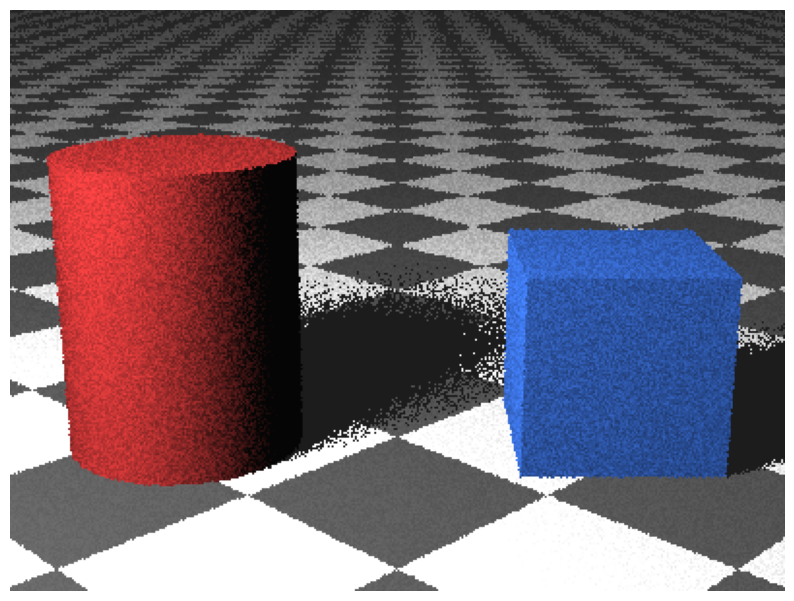

In [4]:
# visualización en memoria
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 8))
img = mpimg.imread("renders/boxcylinder.png")
plt.imshow(img)
plt.axis('off')
plt.show()


# 2. object transform

In [33]:
%%writefile src/object_transform.py


from src.base import Shape, HitRecord, CastEpsilon
from src.ray import Ray
from src.vector3d import Vector3D

class Matrix3x3:
    def __init__(self, m):
        self.m = m

    def multiply_vector(self, v: Vector3D) -> Vector3D:
        return Vector3D(
            self.m[0][0]*v.x + self.m[0][1]*v.y + self.m[0][2]*v.z,
            self.m[1][0]*v.x + self.m[1][1]*v.y + self.m[1][2]*v.z,
            self.m[2][0]*v.x + self.m[2][1]*v.y + self.m[2][2]*v.z
        )

    def determinant(self) -> float:
        m = self.m
        return (m[0][0] * (m[1][1] * m[2][2] - m[1][2] * m[2][1]) -
                m[0][1] * (m[1][0] * m[2][2] - m[1][2] * m[2][0]) +
                m[0][2] * (m[1][0] * m[2][1] - m[1][1] * m[2][0]))

    def inverse(self) -> 'Matrix3x3':
        det = self.determinant()
        if abs(det) < 1e-8:
            raise ValueError("Matriz singular")
        inv_det = 1.0 / det
        m = self.m
        inv = [
            [(m[1][1]*m[2][2] - m[1][2]*m[2][1])*inv_det, (m[0][2]*m[2][1] - m[0][1]*m[2][2])*inv_det, (m[0][1]*m[1][2] - m[0][2]*m[1][1])*inv_det],
            [(m[1][2]*m[2][0] - m[1][0]*m[2][2])*inv_det, (m[0][0]*m[2][2] - m[0][2]*m[2][0])*inv_det, (m[0][2]*m[1][0] - m[0][0]*m[1][2])*inv_det],
            [(m[1][0]*m[2][1] - m[1][1]*m[2][0])*inv_det, (m[0][1]*m[2][0] - m[0][0]*m[2][1])*inv_det, (m[0][0]*m[1][1] - m[0][1]*m[1][0])*inv_det]
        ]
        return Matrix3x3(inv)

    def transpose(self) -> 'Matrix3x3':
        m = self.m
        return Matrix3x3([
            [m[0][0], m[1][0], m[2][0]],
            [m[0][1], m[1][1], m[2][1]],
            [m[0][2], m[1][2], m[2][2]]
        ])

    def __matmul__(self, other: 'Matrix3x3') -> 'Matrix3x3':
        m1 = self.m
        m2 = other.m
        return Matrix3x3([
            [sum(m1[0][k]*m2[k][0] for k in range(3)), sum(m1[0][k]*m2[k][1] for k in range(3)), sum(m1[0][k]*m2[k][2] for k in range(3))],
            [sum(m1[1][k]*m2[k][0] for k in range(3)), sum(m1[1][k]*m2[k][1] for k in range(3)), sum(m1[1][k]*m2[k][2] for k in range(3))],
            [sum(m1[2][k]*m2[k][0] for k in range(3)), sum(m1[2][k]*m2[k][1] for k in range(3)), sum(m1[2][k]*m2[k][2] for k in range(3))]
        ])

    @staticmethod
    def scale(sx: float, sy: float, sz: float) -> 'Matrix3x3':
        return Matrix3x3([
            [sx, 0.0, 0.0],
            [0.0, sy, 0.0],
            [0.0, 0.0, sz]
        ])

    @staticmethod
    def rotate_x(angle_rad: float) -> 'Matrix3x3':
        import math
        c = math.cos(angle_rad)
        s = math.sin(angle_rad)
        return Matrix3x3([
            [1.0, 0.0, 0.0],
            [0.0, c, -s],
            [0.0, s, c]
        ])

    @staticmethod
    def rotate_y(angle_rad: float) -> 'Matrix3x3':
        import math
        c = math.cos(angle_rad)
        s = math.sin(angle_rad)
        return Matrix3x3([
            [c, 0.0, s],
            [0.0, 1.0, 0.0],
            [-s, 0.0, c]
        ])
    
    @staticmethod
    def rotate_z(angle_rad: float) -> 'Matrix3x3':
        import math
        c = math.cos(angle_rad)
        s = math.sin(angle_rad)
        return Matrix3x3([
            [c, -s, 0.0],
            [s, c, 0.0],
            [0.0, 0.0, 1.0]
        ])


class ObjectTransform(Shape):
    def __init__(self, shape: Shape, matrix: Matrix3x3, translation: Vector3D):
        super().__init__("transform")
        self.shape = shape
        self.translation = translation

        self.inv_matrix = matrix.inverse()
        self.inv_trans_matrix = self.inv_matrix.transpose()

    def hit(self, ray: Ray) -> HitRecord:
        local_origin_shifted = ray.origin - self.translation
        local_origin = self.inv_matrix.multiply_vector(local_origin_shifted)
        
        local_direction_raw = self.inv_matrix.multiply_vector(ray.direction)
        direction_magnitude = local_direction_raw.length()
        
        local_ray = Ray(local_origin, local_direction_raw, ray.depth)
        
        hit_rec = self.shape.hit(local_ray)
        
        if not hit_rec.hit:
            return HitRecord(False, float('inf'), None, None)
            
        t_global = hit_rec.t / direction_magnitude
        
        if t_global < CastEpsilon:
            return HitRecord(False, float('inf'), None, None)

        global_point = ray.point_at_parameter(t_global)
        global_normal = self.inv_trans_matrix.multiply_vector(hit_rec.normal).normalize()
        
        return HitRecord(True, t_global, global_point, global_normal, uv=getattr(hit_rec, 'uv', None))



Overwriting src/object_transform.py


In [32]:
%%writefile test_scene2.py
import math
from src.base import BaseScene, Color
from src.shapes import Ball, PlaneUV, Box, Cylinder
from src.object_transform import ObjectTransform, Matrix3x3
from src.camera import Camera
from src.vector3d import Vector3D
from src.light import PointLight
from src.materials import SimpleMaterialWithShadows, CheckerboardMaterial

class Scene(BaseScene):
    def __init__(self):
        super().__init__("obj transform test")

        self.background = Color(0.1, 0.1, 0.12)
        self.ambient_light = Color(0.1, 0.1, 0.1)
        self.max_depth = 4

        self.camera = Camera(
            eye=Vector3D(0.0, -12.0, 6.5),
            look_at=Vector3D(0.0, 0.0, 1.0),
            up=Vector3D(0.0, 0.0, 1.0),
            fov=45,
            img_width=500,
            img_height=300
        )

        # luz lateral
        self.lights = [
            PointLight(position=Vector3D(-8.0, -8.0, 10.0), color=Color(1.0, 1.0, 1.0), intensity=1.5)
        ]

        floor_mat = CheckerboardMaterial(
            ambient_coefficient=0.1, diffuse_coefficient=0.8, square_size=2.0,
            white_color=Color(0.8, 0.8, 0.8), black_color=Color(0.3, 0.3, 0.3)
        )
        
        red_mat = SimpleMaterialWithShadows(0.1, 0.8, Color(0.8, 0.1, 0.1), 0.3, Color(1,1,1), 32)
        green_mat = SimpleMaterialWithShadows(0.1, 0.8, Color(0.1, 0.8, 0.1), 0.3, Color(1,1,1), 32)
        blue_mat = SimpleMaterialWithShadows(0.1, 0.8, Color(0.1, 0.2, 0.8), 0.3, Color(1,1,1), 32)

        # piso
        self.add(PlaneUV(point=Vector3D(0, 0, 0), normal=Vector3D(0, 0, 1), forward_direction=Vector3D(0, 1, 0)), floor_mat)

        # X = -3.5
        # esfera
        self.add(ObjectTransform(
            shape=Ball(Vector3D(0,0,0), 1.0),
            matrix=Matrix3x3.scale(1.0, 1.0, 1.0),
            translation=Vector3D(-3.5, -2.0, 1.0)
        ), red_mat)
        
        # elipsoide
        ellipsoid_matrix = Matrix3x3.rotate_y(math.pi/4) @ Matrix3x3.scale(0.5, 1.0, 1.5)
        self.add(ObjectTransform(
            shape=Ball(Vector3D(0,0,0), 1.0),
            matrix=ellipsoid_matrix,
            translation=Vector3D(-3.5, 2.0, 1.5)
        ), red_mat)

        # X = 0.0
        # caja normal
        self.add(ObjectTransform(
            shape=Box(Vector3D(0,0,0), Vector3D(2.0, 2.0, 2.0)),
            matrix=Matrix3x3.scale(1.0, 1.0, 1.0),
            translation=Vector3D(0.0, -2.0, 1.0)
        ), green_mat)

        # caja deformada
        obb_matrix = Matrix3x3.rotate_z(math.pi/6) @ Matrix3x3.scale(1.5, 0.5, 1.5)
        self.add(ObjectTransform(
            shape=Box(Vector3D(0,0,0), Vector3D(2.0, 2.0, 2.0)),
            matrix=obb_matrix,
            translation=Vector3D(0.0, 2.0, 2.0)
        ), green_mat)

        # X = 3.5
        # cilindro normal
        self.add(ObjectTransform(
            shape=Cylinder(Vector3D(0,0,0), 1.0, 2.0),
            matrix=Matrix3x3.scale(1.0, 1.0, 1.0),
            translation=Vector3D(3.5, -2.0, 1.0)
        ), blue_mat)

        # cilindro deformado
        tilted_cyl_matrix = Matrix3x3.rotate_z(math.pi/2) @ Matrix3x3.rotate_y(math.pi/3) @ Matrix3x3.scale(0.5, 0.5, 2.0)
        self.add(ObjectTransform(
            shape=Cylinder(Vector3D(0,0,0), 1.0, 2.0),
            matrix=tilted_cyl_matrix,
            translation=Vector3D(3.5, 2.0, 1.5)
        ), blue_mat)


Overwriting test_scene2.py


In [3]:
#ejecucion en terminal para que sea mas rapido
!python raster.py -s test_scene2 -n 1 -j 4 -o renders/testscene2.png

Rendering... with anti-aliasing samples: 1
100%|██████████████████████████████████| 150000/150000 [05:22<00:00, 464.64it/s]]]


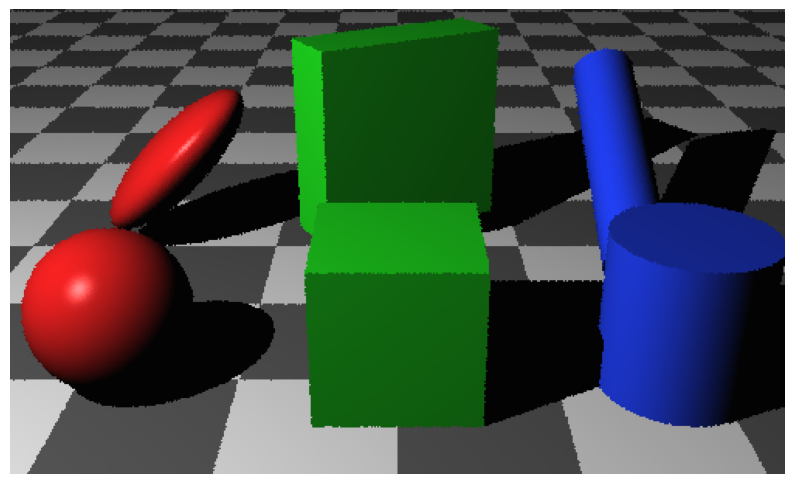

In [4]:
# visualización en memoria
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 8))
img = mpimg.imread("renders/testscene2.png")
plt.imshow(img)
plt.axis('off')
plt.show()


# 3. implicit functions

In [4]:
%%writefile src/surfaces.py
from src.base import Shape, HitRecord, CastEpsilon
from src.vector3d import Vector3D

class AlgebraicSurface(Shape):
    def __init__(self, bounds: Vector3D, step_size: float = 0.05, max_bisection_steps: int = 20):
        super().__init__("algebraic_surface")
        self.bounds = bounds 
        self.step_size = step_size
        self.max_bisection_steps = max_bisection_steps

    def evaluate(self, point: Vector3D) -> float:
        raise NotImplementedError("Subclases deben implementar la función de nivel cero.")

    def gradient(self, point: Vector3D) -> Vector3D:
        eps = 1e-4
        dx = self.evaluate(Vector3D(point.x + eps, point.y, point.z)) - self.evaluate(Vector3D(point.x - eps, point.y, point.z))
        dy = self.evaluate(Vector3D(point.x, point.y + eps, point.z)) - self.evaluate(Vector3D(point.x, point.y - eps, point.z))
        dz = self.evaluate(Vector3D(point.x, point.y, point.z + eps)) - self.evaluate(Vector3D(point.x, point.y, point.z - eps))
        return Vector3D(dx, dy, dz)

    def hit(self, ray):
        t_min = float('-inf')
        t_max = float('inf')

        axes = [
            (ray.origin.x, ray.direction.x, self.bounds.x),
            (ray.origin.y, ray.direction.y, self.bounds.y),
            (ray.origin.z, ray.direction.z, self.bounds.z)
        ]

        for o, d, bound in axes:
            if abs(d) > 1e-6:
                inv_d = 1.0 / d
                t0 = (-bound - o) * inv_d
                t1 = (bound - o) * inv_d
                if t0 > t1:
                    t0, t1 = t1, t0
                t_min = max(t_min, t0)
                t_max = min(t_max, t1)
                
                if t_min > t_max:
                    return HitRecord(False, float('inf'), None, None)
            elif abs(o) > bound:
                return HitRecord(False, float('inf'), None, None)

        if t_max < CastEpsilon:
            return HitRecord(False, float('inf'), None, None)

        t_in = max(t_min, CastEpsilon)
        t_out = t_max

        t_current = t_in
        f_current = self.evaluate(ray.point_at_parameter(t_current))

        while t_current < t_out:
            t_next = t_current + self.step_size
            if t_next > t_out:
                t_next = t_out
            
            f_next = self.evaluate(ray.point_at_parameter(t_next))

            if f_current * f_next <= 0:
                t_a = t_current
                t_b = t_next
                for _ in range(self.max_bisection_steps):
                    t_mid = (t_a + t_b) * 0.5
                    f_mid = self.evaluate(ray.point_at_parameter(t_mid))
                    
                    if f_mid == 0.0:
                        t_a = t_mid
                        break
                    elif (f_current * f_mid) < 0:
                        t_b = t_mid
                    else:
                        t_a = t_mid
                        f_current = f_mid
                
                t_hit = t_a
                hit_point = ray.point_at_parameter(t_hit)
                normal_vec = self.gradient(hit_point)
                
                try:
                    hit_normal = normal_vec.normalize()
                except ValueError:
                    return HitRecord(False, float('inf'), None, None)

                return HitRecord(True, t_hit, hit_point, hit_normal)

            t_current = t_next
            f_current = f_next

        return HitRecord(False, float('inf'), None, None)


class MitchelSurface(AlgebraicSurface):
    def __init__(self):
        super().__init__(bounds=Vector3D(2.5, 2.5, 2.5), step_size=0.02)

    def evaluate(self, p: Vector3D) -> float:
        x2 = p.x * p.x
        y2 = p.y * p.y
        z2 = p.z * p.z
        
        y2_z2 = y2 + z2
        x4 = x2 * x2
        
        return 4.0 * (x4 + y2_z2 * y2_z2 + 17.0 * x2 * y2_z2) - 20.0 * (x2 + y2 + z2) + 17.0


class HeartSurface(AlgebraicSurface):
    def __init__(self):
        super().__init__(bounds=Vector3D(1.5, 1.5, 1.5), step_size=0.02)

    def evaluate(self, p: Vector3D) -> float:
        x2 = p.x * p.x
        y2 = p.y * p.y
        z2 = p.z * p.z
        z3 = z2 * p.z
        
        base = x2 + 2.25 * y2 + z2 - 1.0
        return (base * base * base) - (x2 * z3) - (0.1125 * y2 * z3)


Overwriting src/surfaces.py


In [5]:
%%writefile algebraic_scene.py

import math
from src.base import BaseScene, Color
from src.shapes import PlaneUV
from src.object_transform import ObjectTransform, Matrix3x3
from src.surfaces import MitchelSurface, HeartSurface
from src.camera import Camera
from src.vector3d import Vector3D
from src.light import PointLight
from src.materials import SimpleMaterialWithShadows, CheckerboardMaterial

class Scene(BaseScene):
    def __init__(self):
        super().__init__("Algebraic Surfaces")

        self.background = Color(0.05, 0.05, 0.05)
        self.ambient_light = Color(0.1, 0.1, 0.1)
        self.max_depth = 4
        
        self.camera = Camera(
            eye=Vector3D(0.0, -10.0, 1.5),
            look_at=Vector3D(0.0, 0.0, 0.5),
            up=Vector3D(0.0, 0.0, 1.0),
            fov=45,
            img_width=400,
            img_height=300
        )

        self.lights = [
            PointLight(position=Vector3D(-4.0, -6.0, 6.0), color=Color(1.0, 1.0, 1.0), intensity=1.5),
            PointLight(position=Vector3D(4.0, -6.0, 6.0), color=Color(1.0, 1.0, 1.0), intensity=1.5)
        ]

        floor_mat = CheckerboardMaterial(
            ambient_coefficient=0.1, diffuse_coefficient=0.6, square_size=1.0,
            white_color=Color(0.7, 0.7, 0.7), black_color=Color(0.2, 0.2, 0.2)
        )
        
        red_mat = SimpleMaterialWithShadows(
            ambient_coefficient=0.1, diffuse_coefficient=0.8, diffuse_color=Color(0.8, 0.05, 0.05),
            specular_coefficient=0.6, specular_color=Color(1.0, 0.8, 0.8), specular_shininess=64
        )

        metal_mat = SimpleMaterialWithShadows(
            ambient_coefficient=0.1, diffuse_coefficient=0.5, diffuse_color=Color(0.6, 0.6, 0.7),
            specular_coefficient=0.9, specular_color=Color(1.0, 1.0, 1.0), specular_shininess=128
        )

        # piso
        self.add(PlaneUV(point=Vector3D(0, 0, -1.5), normal=Vector3D(0, 0, 1), forward_direction=Vector3D(0, 1, 0)), floor_mat)

        # corazon
        heart_matrix = Matrix3x3.scale(1.2, 1.2, 1.2)
        self.add(ObjectTransform(
            shape=HeartSurface(),
            matrix=heart_matrix,
            translation=Vector3D(-2.0, 0.0, 0.0)
        ), red_mat)

        # mitchel
        mitchel_matrix = Matrix3x3.scale(1.0, 1.0, 1.0)
        self.add(ObjectTransform(
            shape=MitchelSurface(),
            matrix=mitchel_matrix,
            translation=Vector3D(2.0, 0.0, 0.0)
        ), metal_mat)


Overwriting algebraic_scene.py


In [26]:
#ejecucion en terminal para que sea mas rapido
!python raster.py -s algebraic_scene -n 1 -j 4 -o renders/algebraic_scene.png

Rendering... with anti-aliasing samples: 1
100%|██████████████████████████████████| 120000/120000 [03:04<00:00, 650.60it/s]s]


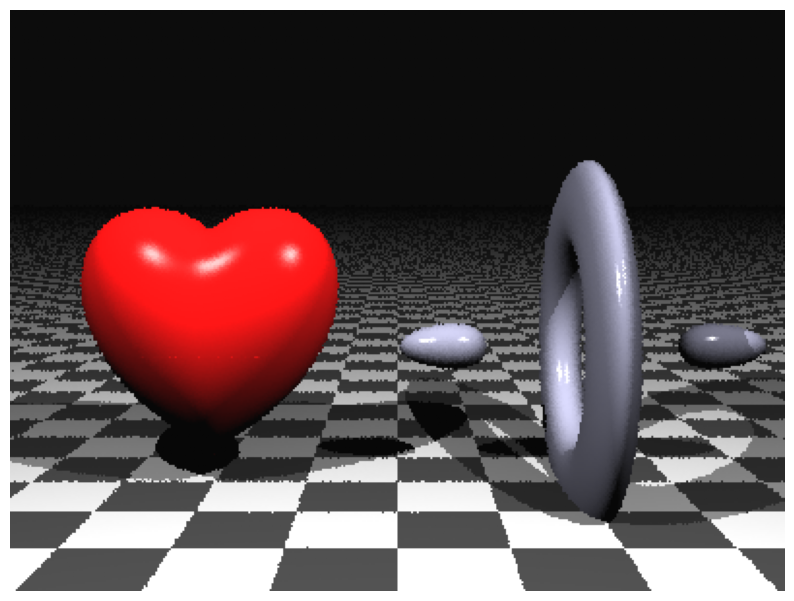

In [27]:
# visualización en memoria
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 8))
img = mpimg.imread("renders/algebraic_scene.png")
plt.imshow(img)
plt.axis('off')
plt.show()


# 4. mirror

In [1]:
# %load src/materials.py

class MirrorMaterial(Material):
    def __init__(self, reflection_coefficient: float = 1.0):
        super().__init__()
        self.reflection_coefficient = reflection_coefficient

    def shade(self, hit_record, scene):
        # profundidad reflejo
        if hit_record.ray.depth >= scene.max_depth:
            return scene.background * self.reflection_coefficient

        incident = hit_record.ray.direction
        normal = hit_record.normal

        if incident.dot(normal) > 0:
            normal = -normal

        #  ecuacion reflexion ideal
        reflect_dir = (incident - normal * 2 * incident.dot(normal)).normalize()

        # rayo secundario
        reflect_origin = hit_record.point + normal * CastEpsilon
        reflect_ray = Ray(reflect_origin, reflect_dir, hit_record.ray.depth + 1)
        
        reflect_hit = scene.hit(reflect_ray)

        # evaluacion recursiva
        if reflect_hit.hit:
            reflected_color = reflect_hit.material.shade(reflect_hit, scene)
        else:
            reflected_color = scene.background

        return reflected_color * self.reflection_coefficient


## escena 1

In [2]:
%%writefile mirror_scene.py
import math
from src.base import BaseScene, Color
from src.shapes import Ball, Box, PlaneUV, Cylinder
from src.object_transform import ObjectTransform, Matrix3x3
from src.camera import Camera
from src.vector3d import Vector3D
from src.light import PointLight
from src.materials import SimpleMaterialWithShadows, CheckerboardMaterial
from src.materials import MirrorMaterial

class Scene(BaseScene):
    def __init__(self):
        super().__init__("espejo tunel1")

        self.background = Color(0.01, 0.01, 0.01)
        self.ambient_light = Color(0.1, 0.1, 0.1)
        self.max_depth = 12

        self.camera = Camera(
            eye=Vector3D(0.0, -8.0, 5.0),
            look_at=Vector3D(0.0, 15.0, 1.5),
            up=Vector3D(0.0, 0.0, 1.0),
            fov=60,
            img_width=500,
            img_height=400
        )

        self.lights = [
            PointLight(position=Vector3D(0.0, -5.0, 8.0), color=Color(1.0, 1.0, 1.0), intensity=1.2),
            PointLight(position=Vector3D(0.0, 5.0, 8.0), color=Color(0.9, 0.9, 1.0), intensity=1.2),
            PointLight(position=Vector3D(0.0, 15.0, 8.0), color=Color(1.0, 0.8, 0.6), intensity=1.5)
        ]

        mirror_mat = MirrorMaterial(reflection_coefficient=0.95) # 95% de reflejo para que se oscurezca al fondo
        floor_mat = CheckerboardMaterial(0.1, 0.7, 2.0, Color(0.9, 0.9, 0.9), Color(0.1, 0.1, 0.1))
        
        red_mat = SimpleMaterialWithShadows(0.1, 0.8, Color(0.9, 0.1, 0.1), 0.7, Color(1,1,1), 64)
        blue_mat = SimpleMaterialWithShadows(0.1, 0.8, Color(0.1, 0.2, 0.9), 0.7, Color(1,1,1), 64)
        gold_mat = SimpleMaterialWithShadows(0.1, 0.6, Color(0.8, 0.6, 0.1), 0.9, Color(1,1,1), 128)

        # piso
        self.add(PlaneUV(Vector3D(0, 0, 0), Vector3D(0, 0, 1), Vector3D(0, 1, 0)), floor_mat)

        # --- ESPEJOS ---
        # espejo frente a la camara
        self.add(ObjectTransform(
            shape=Box(Vector3D(0,0,0), Vector3D(2.0, 2.0, 2.0)),
            matrix=Matrix3x3.scale(12.0, 0.1, 12.0),
            translation=Vector3D(0.0, 20.0, 10.0)
        ), mirror_mat)

        # espejo detras
        self.add(ObjectTransform(
            shape=Box(Vector3D(0,0,0), Vector3D(2.0, 2.0, 2.0)),
            matrix=Matrix3x3.scale(12.0, 0.1, 12.0),
            translation=Vector3D(0.0, -12.0, 10.0)
        ), mirror_mat)

        # esfera roja
        self.add(Ball(Vector3D(-3.5, 0.0, 2.0), 2.0), red_mat)
        
        # esfera azul
        self.add(Ball(Vector3D(4.0, 8.0, 2.5), 2.5), blue_mat)
        
        # cilindro
        cyl_matrix = Matrix3x3.rotate_x(math.pi/2) @ Matrix3x3.rotate_z(math.pi/6) @ Matrix3x3.scale(1.2, 1.2, 4.0)
        self.add(ObjectTransform(
            shape=Cylinder(Vector3D(0,0,0), 1.0, 2.0),
            matrix=cyl_matrix,
            translation=Vector3D(1.5, 4.0, 1.2)
        ), gold_mat)


Overwriting mirror_scene.py


In [54]:
#ejecucion en terminal para que sea mas rapido
!python raster.py -s mirror_scene -n 1 -j 4 -o renders/mirror_scene.png

Rendering... with anti-aliasing samples: 1
100%|██████████████████████████████████| 200000/200000 [06:49<00:00, 488.14it/s]]]


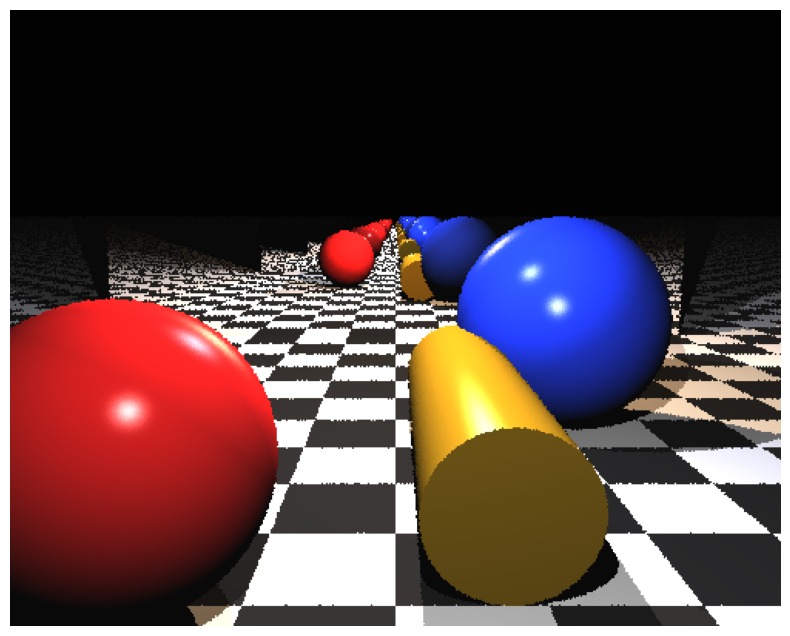

In [55]:
# visualización en memoria
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 8))
img = mpimg.imread("renders/mirror_scene.png")
plt.imshow(img)
plt.axis('off')
plt.show()


## escena 2

In [3]:
%%writefile mirror_scene2.py
import math
import os
from src.base import BaseScene, Color
from src.shapes import Ball, Box, PlaneUV, Cylinder
from src.object_transform import ObjectTransform, Matrix3x3
from src.camera import Camera
from src.vector3d import Vector3D
from src.light import PointLight
from src.materials import SimpleMaterialWithShadows, CheckerboardMaterial
from src.materials import MirrorMaterial

class Scene(BaseScene):
    def __init__(self):
        super().__init__("espejo tunel2")

        self.background = Color(0.01, 0.01, 0.01)
        self.ambient_light = Color(0.1, 0.1, 0.1)
        self.max_depth = int(os.environ.get('RAYTRACER_MAX_DEPTH', 12)) 
        
        self.camera = Camera(
            eye=Vector3D(0.0, -8.0, 5.0),
            look_at=Vector3D(0.0, 15.0, 1.5),
            up=Vector3D(0.0, 0.0, 1.0),
            fov=60,
            img_width=500,
            img_height=400
        )

        self.lights = [
            PointLight(position=Vector3D(0.0, -5.0, 8.0), color=Color(1.0, 1.0, 1.0), intensity=1.2),
            PointLight(position=Vector3D(0.0, 5.0, 8.0), color=Color(0.9, 0.9, 1.0), intensity=1.2),
            PointLight(position=Vector3D(0.0, 15.0, 8.0), color=Color(1.0, 0.8, 0.6), intensity=1.5)
        ]

        mirror_mat = MirrorMaterial(reflection_coefficient=0.95) # 95% de reflejo para que se oscurezca al fondo
        floor_mat = CheckerboardMaterial(0.1, 0.7, 2.0, Color(0.9, 0.9, 0.9), Color(0.1, 0.1, 0.1))
        
        red_mat = SimpleMaterialWithShadows(0.1, 0.8, Color(0.9, 0.1, 0.1), 0.7, Color(1,1,1), 64)
        blue_mat = SimpleMaterialWithShadows(0.1, 0.8, Color(0.1, 0.2, 0.9), 0.7, Color(1,1,1), 64)
        gold_mat = SimpleMaterialWithShadows(0.1, 0.6, Color(0.8, 0.6, 0.1), 0.9, Color(1,1,1), 128)

        # piso
        self.add(PlaneUV(Vector3D(0, 0, 0), Vector3D(0, 0, 1), Vector3D(0, 1, 0)), floor_mat)

        # espejo frontal
        self.add(ObjectTransform(
            shape=Box(Vector3D(0,0,0), Vector3D(2.0, 2.0, 2.0)),
            matrix=Matrix3x3.scale(12.0, 0.1, 12.0),
            translation=Vector3D(0.0, 20.0, 10.0)
        ), mirror_mat)

        # espejo atras
        self.add(ObjectTransform(
            shape=Box(Vector3D(0,0,0), Vector3D(2.0, 2.0, 2.0)),
            matrix=Matrix3x3.scale(12.0, 0.1, 12.0),
            translation=Vector3D(0.0, -12.0, 10.0)
        ), mirror_mat)

        box_shape = Box(Vector3D(0,0,0), Vector3D(2.0, 2.0, 2.0))
        cyl_shape = Cylinder(Vector3D(0,0,0), 1.0, 2.0)

        m_box_top = Matrix3x3.rotate_y(-math.pi/4) @ Matrix3x3.scale(0.5, 0.5, 2.0)
        self.add(ObjectTransform(
            shape=box_shape,
            matrix=m_box_top,
            translation=Vector3D(-3.0, 5.0, 5.0)
        ), red_mat)

        m_box_bot = Matrix3x3.rotate_y(math.pi/4) @ Matrix3x3.scale(0.5, 0.5, 2.0)
        self.add(ObjectTransform(
            shape=box_shape,
            matrix=m_box_bot,
            translation=Vector3D(-3.0, 5.0, 1.5)
        ), red_mat)

        m_cyl_top = Matrix3x3.rotate_y(math.pi/4) @ Matrix3x3.scale(0.6, 0.6, 2.0)
        self.add(ObjectTransform(
            shape=cyl_shape,
            matrix=m_cyl_top,
            translation=Vector3D(3.0, 5.0, 5.0)
        ), gold_mat)

        m_cyl_bot = Matrix3x3.rotate_y(-math.pi/4) @ Matrix3x3.scale(0.6, 0.6, 2.0)
        self.add(ObjectTransform(
            shape=cyl_shape,
            matrix=m_cyl_bot,
            translation=Vector3D(3.0, 5.0, 1.5)
        ), gold_mat)


Overwriting mirror_scene2.py


In [1]:
#ejecucion en terminal para que sea mas rapido
!python raster.py -s mirror_scene2 -n 1 -j 4 -o renders/mirror_scene2.png

Rendering... with anti-aliasing samples: 1
100%|██████████████████████████████████| 200000/200000 [25:28<00:00, 130.83it/s]]]


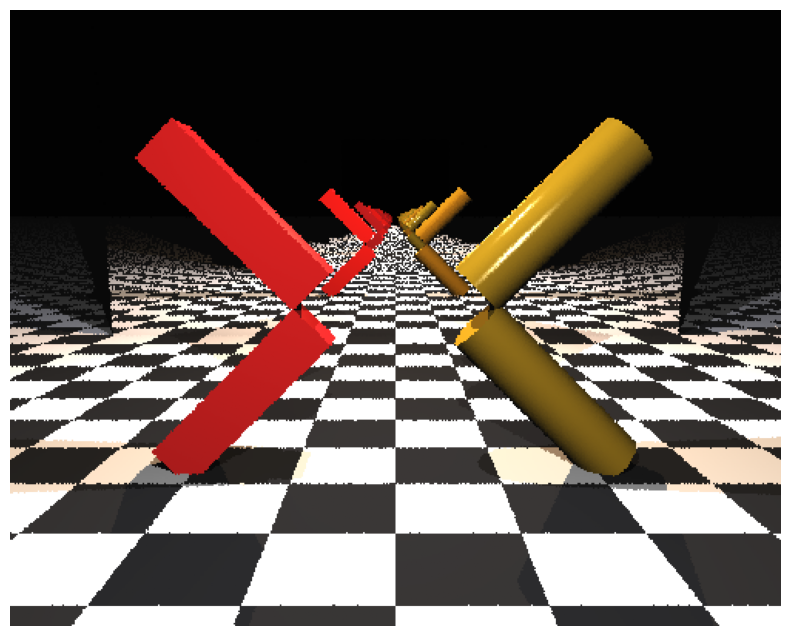

In [2]:
# visualización en memoria
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 8))
img = mpimg.imread("renders/mirror_scene2.png")
plt.imshow(img)
plt.axis('off')
plt.show()


In [1]:
depths = [1, 2, 5, 10]
scene_module = "mirror_scene2"

for d in depths:
    print(f"max_depth = {d}")
    !RAYTRACER_MAX_DEPTH={d} python raster.py -s {scene_module} -n 1 -j 4 -o tunnel_depth_{d}.png


max_depth = 1
Rendering... with anti-aliasing samples: 1
100%|██████████████████████████████████| 200000/200000 [11:27<00:00, 290.88it/s]]]
max_depth = 2
Rendering... with anti-aliasing samples: 1
100%|████████████████��█████████████████| 200000/200000 [07:08<00:00, 467.23it/s]]
max_depth = 5
Rendering... with anti-aliasing samples: 1
100%|██████████████████████████████████| 200000/200000 [14:00<00:00, 238.09it/s]]]
max_depth = 10
Rendering... with anti-aliasing samples: 1
100%|██████████████████████████████████| 200000/200000 [15:15<00:00, 218.53it/s]s]


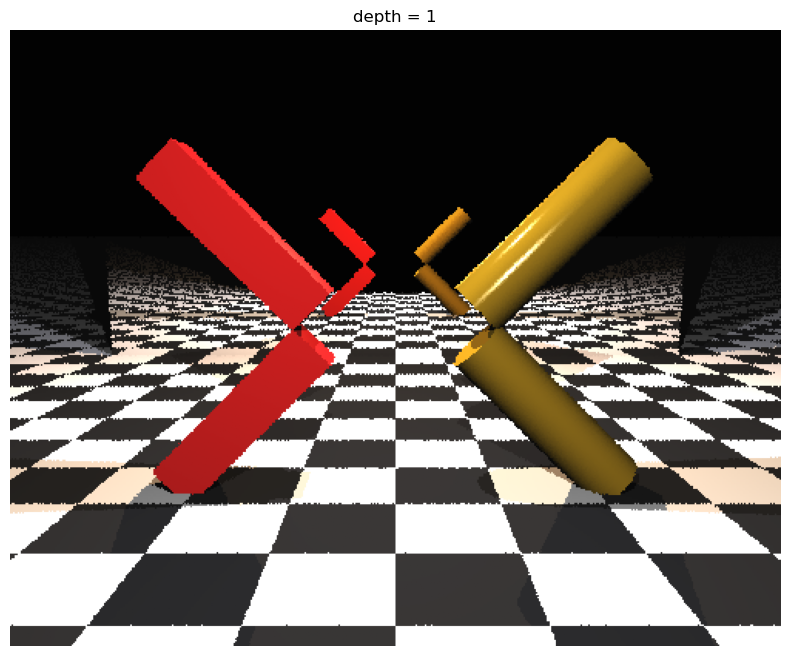

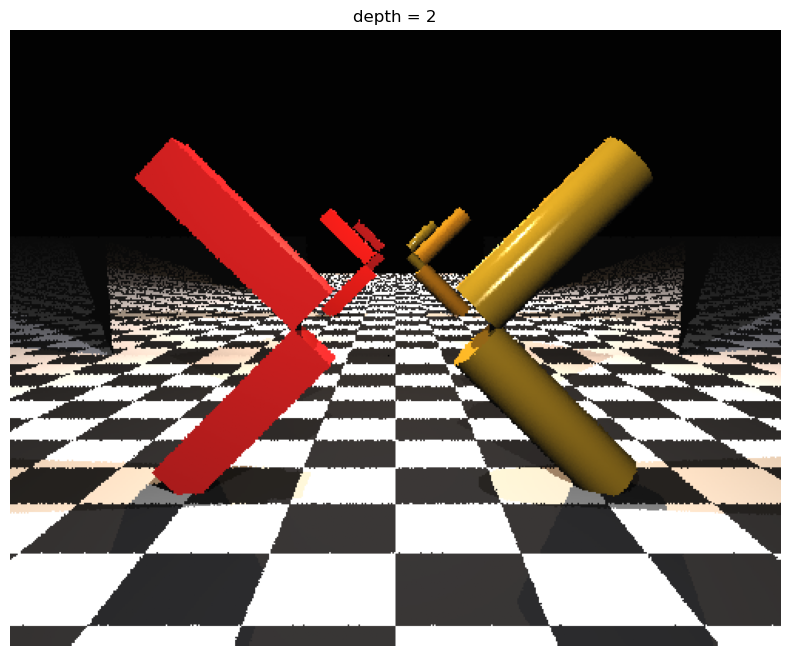

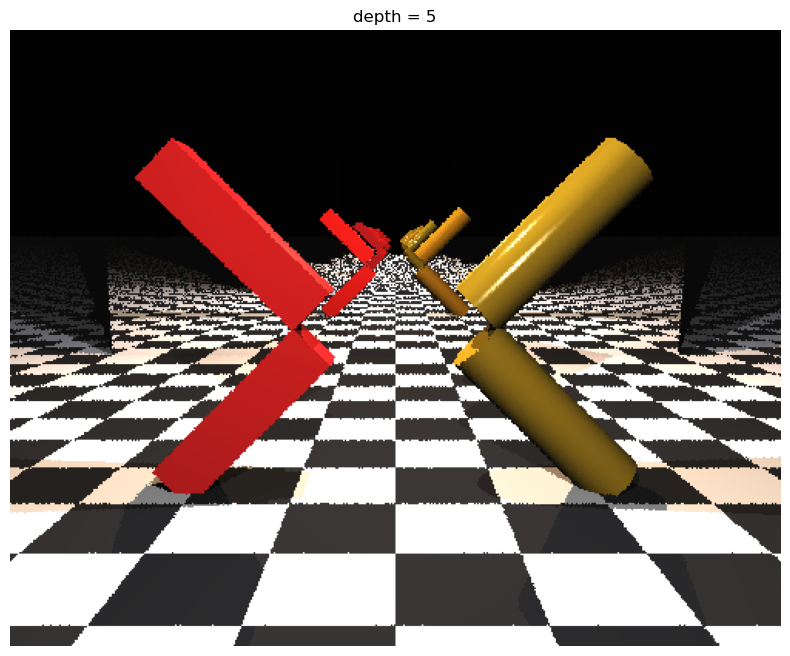

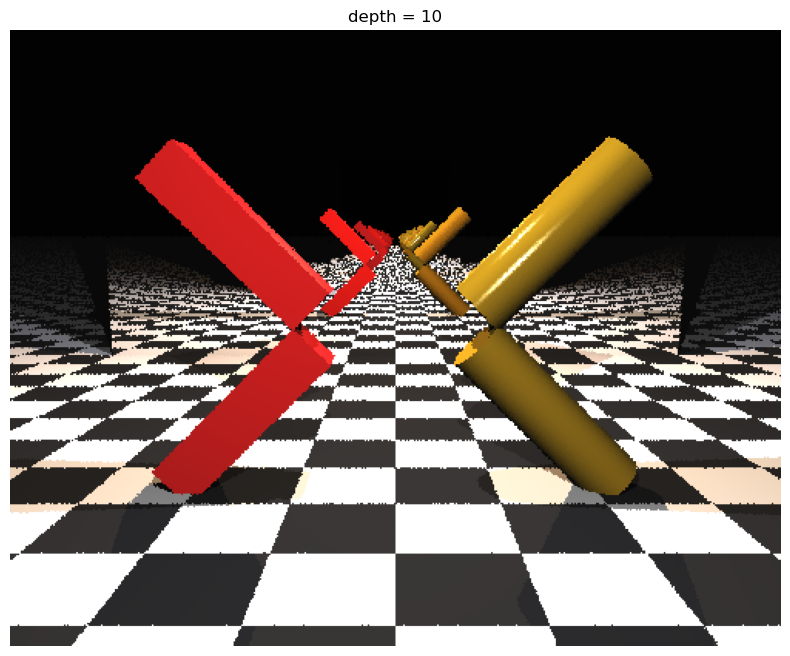

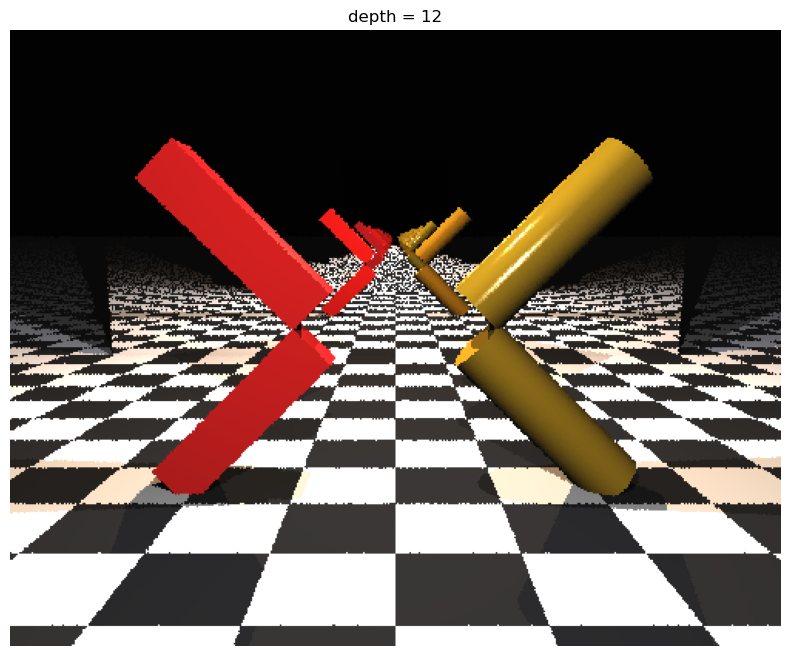

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

depths = [1, 2, 5, 10, 12]

for d in depths:
    plt.figure(figsize=(10, 8))
    img = mpimg.imread(f"renders/tunnel_depth_{d}.png")
    plt.imshow(img)
    plt.title(f"depth = {d}")
    plt.axis('off')
    plt.show()



# 5. depth of field

In [5]:
# %load src/camera.py

def random_in_unit_disk() -> Vector3D:
    while True:
        p = Vector3D(random.uniform(-1.0, 1.0), random.uniform(-1.0, 1.0), 0.0)
        if p.length_squared() < 1.0:
            return p

class ThinLensCamera:
    def __init__(self, eye: Vector3D, look_at: Vector3D, up: Vector3D, fov: float, img_width: int, img_height: int, lens_radius: float, focal_distance: float):
        self.eye = eye
        self.lens_radius = lens_radius
        self.focal_distance = focal_distance
        
        self.img_width = img_width
        self.img_height = img_height
        
        theta = fov * math.pi / 180.0
        half_height = math.tan(theta / 2.0)
        aspect_ratio = img_width / img_height
        half_width = aspect_ratio * half_height
        
        self.w = (eye - look_at).normalize()
        self.u = up.cross(self.w).normalize()
        self.v = self.w.cross(self.u)
        
        self.lower_left_corner = self.eye - self.u * (half_width * focal_distance) - self.v * (half_height * focal_distance) - self.w * focal_distance
        self.horizontal = self.u * (2.0 * half_width * focal_distance)
        self.vertical = self.v * (2.0 * half_height * focal_distance)

    def ray(self, s: float, t: float) -> Ray:
        u = s / self.img_width
        v = t / self.img_height
        
        rd = random_in_unit_disk() * self.lens_radius
        offset = self.u * rd.x + self.v * rd.y
        
        p_focus = self.lower_left_corner + self.horizontal * u + self.vertical * v
        
        new_origin = self.eye + offset
        new_direction = (p_focus - new_origin).normalize()
        
        return Ray(new_origin, new_direction)



## escena

In [6]:
%%writefile focal_scene.py
import math
import os
from src.base import BaseScene, Color
from src.shapes import Ball, Box, PlaneUV, Cylinder
from src.object_transform import ObjectTransform, Matrix3x3
from src.camera import ThinLensCamera
from src.vector3d import Vector3D
from src.light import PointLight
from src.materials import SimpleMaterialWithShadows, CheckerboardMaterial

class Scene(BaseScene):
    def __init__(self):
        super().__init__("Depth of field")

        self.background = Color(0.05, 0.05, 0.05)
        self.ambient_light = Color(0.15, 0.15, 0.15)
        self.max_depth = 3

        f_dist = float(os.environ.get('RAYTRACER_FOCAL_DISTANCE', 10.11))
        
        self.camera = ThinLensCamera(
            eye=Vector3D(0.0, -10.0, 3.0),
            look_at=Vector3D(0.0, 10.0, 3.0),
            up=Vector3D(0.0, 0.0, 1.0),
            fov=50,
            img_width=400,
            img_height=300,
            lens_radius=0.4, 
            focal_distance=f_dist
        )

        self.lights = [
            PointLight(position=Vector3D(0.0, -5.0, 15.0), color=Color(1.0, 1.0, 1.0), intensity=1.5),
            PointLight(position=Vector3D(-8.0, 5.0, 12.0), color=Color(0.8, 0.8, 0.9), intensity=1.0)
        ]

        floor_mat = CheckerboardMaterial(0.1, 0.8, 2.0, Color(0.8, 0.8, 0.8), Color(0.2, 0.2, 0.2))
        red_mat = SimpleMaterialWithShadows(0.1, 0.8, Color(0.9, 0.1, 0.1), 0.5, Color(1,1,1), 32)
        blue_mat = SimpleMaterialWithShadows(0.1, 0.8, Color(0.1, 0.3, 0.9), 0.5, Color(1,1,1), 32)
        gold_mat = SimpleMaterialWithShadows(0.1, 0.7, Color(0.8, 0.6, 0.1), 0.8, Color(1,1,1), 64)

        self.add(PlaneUV(Vector3D(0, 0, 0), Vector3D(0, 0, 1), Vector3D(0, 1, 0)), floor_mat)

        self.add(Ball(Vector3D(0.0, 0.0, 1.5), 1.5), red_mat)

        box_matrix = Matrix3x3.rotate_z(math.pi/4) @ Matrix3x3.rotate_x(math.pi/6)
        self.add(ObjectTransform(
            shape=Box(Vector3D(0,0,0), Vector3D(1.5, 1.5, 1.5)),
            matrix=box_matrix,
            translation=Vector3D(-4.0, 5.0, 5.0)
        ), blue_mat)

        cyl_matrix = Matrix3x3.rotate_y(math.pi/6) @ Matrix3x3.rotate_x(math.pi/4)
        self.add(ObjectTransform(
            shape=Cylinder(Vector3D(0,0,0), 1.0, 3.0),
            matrix=cyl_matrix,
            translation=Vector3D(4.0, 10.0, 6.0)
        ), gold_mat)


In [1]:
import os

focal_distances = [10.11, 15.65, 20.61]
scene_module = "focal_scene"

for fd in focal_distances:
    print(f"d = {fd}...")
    !RAYTRACER_FOCAL_DISTANCE={fd} python raster.py -s {scene_module} -n 64 -j 4 -o renders/focus_{fd}.png


d = 10.11...
Rendering... with anti-aliasing samples: 64
100%|██████████████████████████████████| 120000/120000 [15:10<00:00, 131.79it/s]]]
d = 15.65...
Rendering... with anti-aliasing samples: 64
100%|██████████████████████████████████| 120000/120000 [16:55<00:00, 118.11it/s]]]
d = 20.61...
Rendering... with anti-aliasing samples: 64
100%|██████████████████████████████████| 120000/120000 [18:09<00:00, 110.12it/s]s]


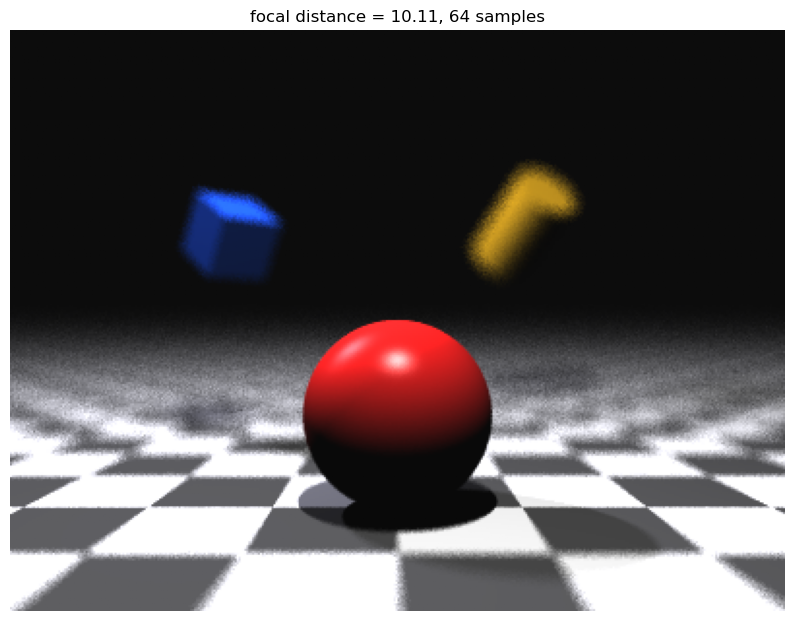

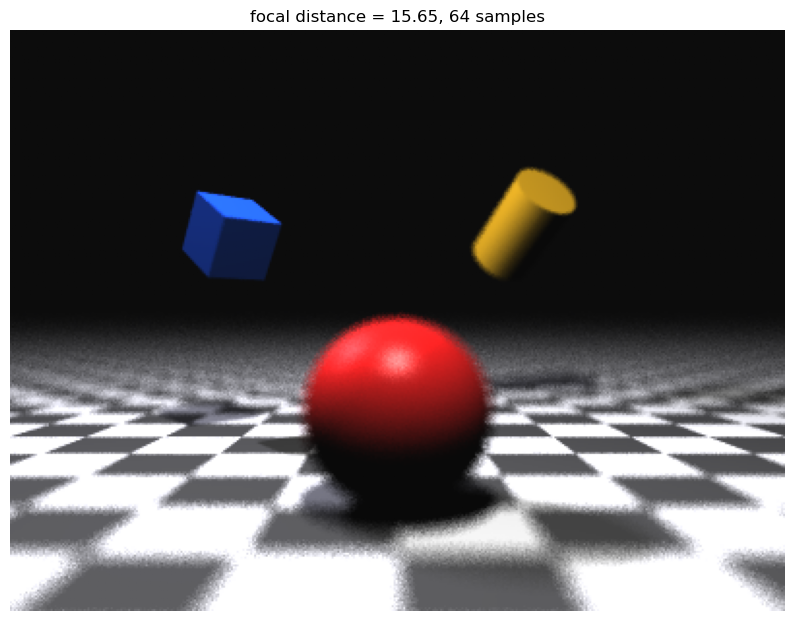

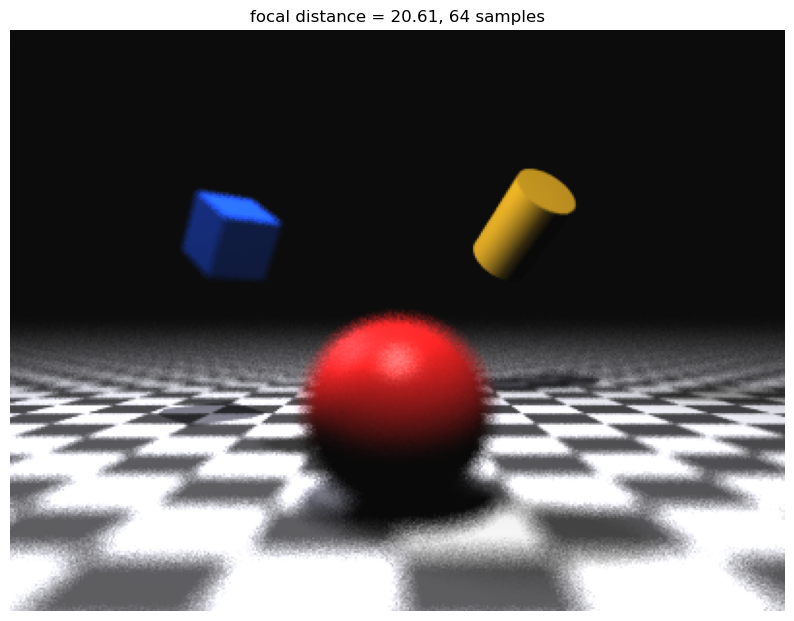

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

focal_distances = [10.11, 15.65, 20.61]

for fd in focal_distances:
    plt.figure(figsize=(10, 8))
    img = mpimg.imread(f"renders/focus_{fd}.png")
    plt.imshow(img)
    plt.title(f"focal distance = {fd}, 64 samples")
    plt.axis('off')
    plt.show()



In [15]:
%%writefile focoradiocero.py
import math
import os
from src.base import BaseScene, Color
from src.shapes import Ball, Box, PlaneUV, Cylinder
from src.object_transform import ObjectTransform, Matrix3x3
from src.camera import ThinLensCamera
from src.vector3d import Vector3D
from src.light import PointLight
from src.materials import SimpleMaterialWithShadows, CheckerboardMaterial

class Scene(BaseScene):
    def __init__(self):
        super().__init__("Depth of field")

        self.background = Color(0.05, 0.05, 0.05)
        self.ambient_light = Color(0.15, 0.15, 0.15)
        self.max_depth = 3

        f_dist = float(os.environ.get('RAYTRACER_FOCAL_DISTANCE', 10.11))
        
        self.camera = ThinLensCamera(
            eye=Vector3D(0.0, -10.0, 3.0),
            look_at=Vector3D(0.0, 10.0, 3.0),
            up=Vector3D(0.0, 0.0, 1.0),
            fov=50,
            img_width=400,
            img_height=300,
            lens_radius=0,
            focal_distance=f_dist
        )

        self.lights = [
            PointLight(position=Vector3D(0.0, -5.0, 15.0), color=Color(1.0, 1.0, 1.0), intensity=1.5),
            PointLight(position=Vector3D(-8.0, 5.0, 12.0), color=Color(0.8, 0.8, 0.9), intensity=1.0)
        ]

        floor_mat = CheckerboardMaterial(0.1, 0.8, 2.0, Color(0.8, 0.8, 0.8), Color(0.2, 0.2, 0.2))
        red_mat = SimpleMaterialWithShadows(0.1, 0.8, Color(0.9, 0.1, 0.1), 0.5, Color(1,1,1), 32)
        blue_mat = SimpleMaterialWithShadows(0.1, 0.8, Color(0.1, 0.3, 0.9), 0.5, Color(1,1,1), 32)
        gold_mat = SimpleMaterialWithShadows(0.1, 0.7, Color(0.8, 0.6, 0.1), 0.8, Color(1,1,1), 64)

        self.add(PlaneUV(Vector3D(0, 0, 0), Vector3D(0, 0, 1), Vector3D(0, 1, 0)), floor_mat)

        self.add(Ball(Vector3D(0.0, 0.0, 1.5), 1.5), red_mat)

        box_matrix = Matrix3x3.rotate_z(math.pi/4) @ Matrix3x3.rotate_x(math.pi/6)
        self.add(ObjectTransform(
            shape=Box(Vector3D(0,0,0), Vector3D(1.5, 1.5, 1.5)),
            matrix=box_matrix,
            translation=Vector3D(-4.0, 5.0, 5.0)
        ), blue_mat)

        cyl_matrix = Matrix3x3.rotate_y(math.pi/6) @ Matrix3x3.rotate_x(math.pi/4)
        self.add(ObjectTransform(
            shape=Cylinder(Vector3D(0,0,0), 1.0, 3.0),
            matrix=cyl_matrix,
            translation=Vector3D(4.0, 10.0, 6.0)
        ), gold_mat)


Writing focoradiocero.py


In [16]:
#ejecucion en terminal para que sea mas rapido
!python raster.py -s focoradiocero -n 64 -j 4 -o renders/imagennitida2.png

Rendering... with anti-aliasing samples: 64
100%|██████████████████████████████████| 120000/120000 [18:15<00:00, 109.54it/s]s]


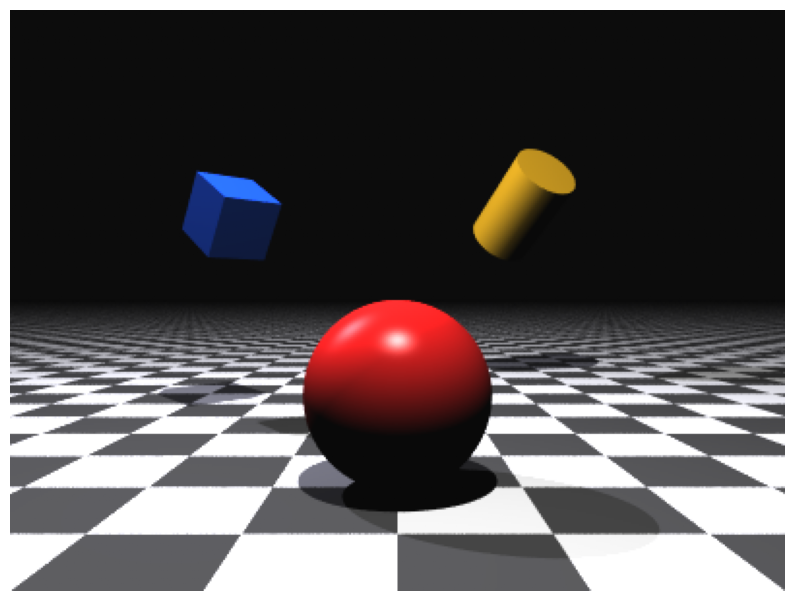

In [17]:
# visualización en memoria
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10, 8))
img = mpimg.imread("renders/imagennitida2.png")
plt.imshow(img)
plt.axis('off')
plt.show()
